# The purpose of notebook is to build factor portfolios using machine learning so as to maximize Sharpe Ratio, Return, Minimize Risk over a holding period

In [16]:
import numpy as np
import sys
sys.path.insert(0, "./ffn-master/")
import ffn
import bt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn import metrics 
import lightgbm as lgb

In [17]:
read_data_all=pd.read_csv('data\Data_Y_nifty500.csv')
read_data_all['Date']= pd.to_datetime(read_data_all['Date'])
holding_period=22  # 1 Month

# Missing value treatment before running ML Model

In [18]:
column_list=['Momentum', 'StDev','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P',
       'Size_Factor','ROE', 'Leverage', 'BVPS','Sales/Price', 'BV/Price','Div/Price']#, 'Quality', 'Value']
for column in column_list:
    read_data_all[read_data_all[column]==""] = np.NaN
    read_data_all[column]=read_data_all.groupby('Symbol')[column].fillna(method='bfill')
    read_data_all[column]=read_data_all.groupby('Symbol')[column].fillna(method='ffill')
#read_data_all=read_data_all.replace([np.inf, -np.inf], np.nan).dropna()
#read_data=read_data_all

In [19]:
column_list=['Momentum', 'StDev','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P',
       'Size_Factor','ROE', 'Leverage', 'BVPS','Sales/Price', 'BV/Price','Div/Price']
for column in column_list:
    read_data_all[column]=np.where(read_data_all[column] > read_data_all[column].quantile(0.99),read_data_all[column].quantile(0.99), read_data_all[column])
    read_data_all[column]=np.where(read_data_all[column] < read_data_all[column].quantile(0.01),read_data_all[column].quantile(0.01), read_data_all[column])

In [20]:
column_list=['Momentum', 'Share_Turnover','StDev','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P',
       'Size_Factor','ROE', 'Leverage', 'BVPS','Sales/Price', 'BV/Price','Div/Price']
for column in column_list:
    read_data_all[column]=read_data_all.groupby('Date')[column].rank(ascending=1)

In [21]:
read_data=read_data_all

# Calculate the Return over next Month(holding period)

In [22]:
symbol_list=read_data['Symbol'].unique().tolist()
data2=pd.DataFrame()
count =1 
for symbol in symbol_list:
    print("Processing for Symbol: ",count, symbol)
    data1=read_data[read_data['Symbol']==symbol]
    data1['Cum_Return']=(1+data1['Return']).rolling(holding_period,min_periods=1).apply(np.prod)-1
    data2=data2.append(data1)
    count=count+1
read_data=data2
read_data['Cum_Return']=read_data.groupby("Symbol")['Cum_Return'].shift(holding_period*-1)
#read_data=read_data[read_data['Date']>='2012-01-02']   ####For Yearly Data 
read_data=read_data[read_data['Date']>='9/1/2012']    ####For Quarterly Data

Processing for Symbol:  1 ACC
Processing for Symbol:  2 ABBOTINDIA
Processing for Symbol:  3 ADANIGREEN
Processing for Symbol:  4 ADANIPORTS
Processing for Symbol:  5 ADANITRANS
Processing for Symbol:  6 ALKEM
Processing for Symbol:  7 AMBUJACEM
Processing for Symbol:  8 ASIANPAINT
Processing for Symbol:  9 AUROPHARMA
Processing for Symbol:  10 DMART
Processing for Symbol:  11 BAJAJ-AUTO
Processing for Symbol:  12 BERGEPAINT
Processing for Symbol:  13 BPCL
Processing for Symbol:  14 BHARTIARTL
Processing for Symbol:  15 BIOCON
Processing for Symbol:  16 BOSCHLTD
Processing for Symbol:  17 BRITANNIA
Processing for Symbol:  18 CADILAHC
Processing for Symbol:  19 CIPLA
Processing for Symbol:  20 COALINDIA
Processing for Symbol:  21 CONCOR
Processing for Symbol:  22 DABUR
Processing for Symbol:  23 DIVISLAB
Processing for Symbol:  24 DRREDDY
Processing for Symbol:  25 EICHERMOT
Processing for Symbol:  26 GAIL
Processing for Symbol:  27 GODREJCP
Processing for Symbol:  28 GRASIM
Processing 

Processing for Symbol:  230 FINEORG
Processing for Symbol:  231 FINCABLES
Processing for Symbol:  232 FINPIPE
Processing for Symbol:  233 FSL
Processing for Symbol:  234 GEPIL
Processing for Symbol:  235 GHCL
Processing for Symbol:  236 GMMPFAUDLR
Processing for Symbol:  237 GALAXYSURF
Processing for Symbol:  238 GRSE
Processing for Symbol:  239 GARFIBRES
Processing for Symbol:  240 GODFRYPHLP
Processing for Symbol:  241 GRANULES
Processing for Symbol:  242 GRAPHITE
Processing for Symbol:  243 GESHIP
Processing for Symbol:  244 GREAVESCOT
Processing for Symbol:  245 GRINDWELL
Processing for Symbol:  246 GUJALKALI
Processing for Symbol:  247 GAEL
Processing for Symbol:  248 FLUOROCHEM
Processing for Symbol:  249 GMDCLTD
Processing for Symbol:  250 GNFC
Processing for Symbol:  251 GPPL
Processing for Symbol:  252 GSFC
Processing for Symbol:  253 GULFOILLUB
Processing for Symbol:  254 HEG
Processing for Symbol:  255 HEIDELBERG
Processing for Symbol:  256 HERITGFOOD
Processing for Symbol: 

In [23]:
class_report=pd.DataFrame()
read_data['Date']= pd.to_datetime(read_data['Date'])
read_data_forecast=read_data.dropna()
read_data_forecast=read_data_forecast[read_data_forecast['Date']<'12/13/2020']
read_data.Date.max()

Timestamp('2020-12-11 00:00:00')

# Now run the ML Model(Light GBM and test evaluate over datasets)

In [28]:
############################Lite GBM
test_predict=[0.02,0.05,0.075]
predict_frame=pd.DataFrame() 
count=1
for predict_period in test_predict:    
    print("Now running for prediction_hit: ", predict_period*100,'% Return over holding period')
    read_data_forecast['Cum_Cat_Label']=np.where(read_data_forecast['Cum_Return']>predict_period, 1, 0)
    read_data_forecast[read_data_forecast['Cum_Cat_Label']==1].count()/read_data_forecast[read_data_forecast['Cum_Cat_Label']==0].count()
    event_rate=read_data_forecast[read_data_forecast['Cum_Cat_Label']==1].count()/read_data_forecast['Cum_Cat_Label'].count()
    event_cut_off=1-event_rate.iloc[0]   
    Y_Label=read_data_forecast['Cum_Cat_Label']
    Y_Label=np.array(Y_Label)
    sc = StandardScaler()
    X_Features=read_data_forecast[['Momentum', 'StDev','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P',
       'Size_Factor','ROE', 'Leverage','Sales/Price', 'BV/Price','Div/Price']]
    X_Features=np.array(X_Features)
    X_train, X_test, y_train, y_test = train_test_split(X_Features, Y_Label, test_size=0.2, random_state=0)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    d_train = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    parameters = {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'is_unbalance': 'true',
        'boosting': 'gbdt',
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'bagging_freq': 20,
        'learning_rate': 0.05,
        'max_bin':200,
        'num_leaves': 900,
        'max_depth': 50,
        'verbose': -1
    }
    lgbm = lgb.train(parameters, d_train,valid_sets=test_data,num_boost_round=1500,early_stopping_rounds=100)
    y_train_pred = lgbm.predict(X_train)
    y_train_pred = np.where(y_train_pred > event_cut_off, 1, 0)
    y_test_pred = lgbm.predict(X_test)
    y_test_pred = np.where(y_test_pred > event_cut_off, 1, 0)
    print("Train Confusion Matrix:", confusion_matrix(y_train,y_train_pred))
    #print("Test Confusion Matrix:", confusion_matrix(y_test,y_test_pred))
    print("Train Classification Report:",classification_report(y_train,y_train_pred))
    print("Test Classification Report:",classification_report(y_test,y_test_pred))
    print(accuracy_score(y_test, y_test_pred))
    var_name="LGBM_Prob_"+str(predict_period*100)+'%hit'  
    read_data[var_name]=lgbm.predict(sc.fit_transform(read_data[['Momentum', 'StDev','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P',
       'Size_Factor','ROE', 'Leverage', 'Sales/Price', 'BV/Price','Div/Price']].values))  
    print("Now Done for prediction_hit: ", predict_period)

Now running for prediction_hit:  2.0 % Return over holding period
[1]	valid_0's binary_logloss: 0.681487
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.677345
[3]	valid_0's binary_logloss: 0.672697
[4]	valid_0's binary_logloss: 0.668258
[5]	valid_0's binary_logloss: 0.66434
[6]	valid_0's binary_logloss: 0.660347
[7]	valid_0's binary_logloss: 0.656247
[8]	valid_0's binary_logloss: 0.652891
[9]	valid_0's binary_logloss: 0.649169
[10]	valid_0's binary_logloss: 0.64602
[11]	valid_0's binary_logloss: 0.642691
[12]	valid_0's binary_logloss: 0.639443
[13]	valid_0's binary_logloss: 0.636488
[14]	valid_0's binary_logloss: 0.633413
[15]	valid_0's binary_logloss: 0.630835
[16]	valid_0's binary_logloss: 0.628247
[17]	valid_0's binary_logloss: 0.625719
[18]	valid_0's binary_logloss: 0.623194
[19]	valid_0's binary_logloss: 0.620856
[20]	valid_0's binary_logloss: 0.618305
[21]	valid_0's binary_logloss: 0.615855
[22]	valid_0's binary_logloss: 0.613273
[23

[201]	valid_0's binary_logloss: 0.450725
[202]	valid_0's binary_logloss: 0.45021
[203]	valid_0's binary_logloss: 0.449661
[204]	valid_0's binary_logloss: 0.449213
[205]	valid_0's binary_logloss: 0.448713
[206]	valid_0's binary_logloss: 0.44828
[207]	valid_0's binary_logloss: 0.447873
[208]	valid_0's binary_logloss: 0.447386
[209]	valid_0's binary_logloss: 0.446975
[210]	valid_0's binary_logloss: 0.446578
[211]	valid_0's binary_logloss: 0.446092
[212]	valid_0's binary_logloss: 0.445671
[213]	valid_0's binary_logloss: 0.445183
[214]	valid_0's binary_logloss: 0.444812
[215]	valid_0's binary_logloss: 0.444391
[216]	valid_0's binary_logloss: 0.444004
[217]	valid_0's binary_logloss: 0.443571
[218]	valid_0's binary_logloss: 0.443252
[219]	valid_0's binary_logloss: 0.4428
[220]	valid_0's binary_logloss: 0.442455
[221]	valid_0's binary_logloss: 0.441974
[222]	valid_0's binary_logloss: 0.44156
[223]	valid_0's binary_logloss: 0.441164
[224]	valid_0's binary_logloss: 0.440689
[225]	valid_0's binar

[403]	valid_0's binary_logloss: 0.385729
[404]	valid_0's binary_logloss: 0.385515
[405]	valid_0's binary_logloss: 0.385323
[406]	valid_0's binary_logloss: 0.38508
[407]	valid_0's binary_logloss: 0.384833
[408]	valid_0's binary_logloss: 0.384577
[409]	valid_0's binary_logloss: 0.384314
[410]	valid_0's binary_logloss: 0.384106
[411]	valid_0's binary_logloss: 0.383904
[412]	valid_0's binary_logloss: 0.383704
[413]	valid_0's binary_logloss: 0.383469
[414]	valid_0's binary_logloss: 0.383246
[415]	valid_0's binary_logloss: 0.383041
[416]	valid_0's binary_logloss: 0.382844
[417]	valid_0's binary_logloss: 0.382631
[418]	valid_0's binary_logloss: 0.382431
[419]	valid_0's binary_logloss: 0.38229
[420]	valid_0's binary_logloss: 0.382043
[421]	valid_0's binary_logloss: 0.381828
[422]	valid_0's binary_logloss: 0.381597
[423]	valid_0's binary_logloss: 0.381389
[424]	valid_0's binary_logloss: 0.381213
[425]	valid_0's binary_logloss: 0.381025
[426]	valid_0's binary_logloss: 0.380804
[427]	valid_0's bi

[605]	valid_0's binary_logloss: 0.350848
[606]	valid_0's binary_logloss: 0.350738
[607]	valid_0's binary_logloss: 0.350627
[608]	valid_0's binary_logloss: 0.350506
[609]	valid_0's binary_logloss: 0.350358
[610]	valid_0's binary_logloss: 0.350219
[611]	valid_0's binary_logloss: 0.350114
[612]	valid_0's binary_logloss: 0.350019
[613]	valid_0's binary_logloss: 0.349886
[614]	valid_0's binary_logloss: 0.349742
[615]	valid_0's binary_logloss: 0.349618
[616]	valid_0's binary_logloss: 0.349494
[617]	valid_0's binary_logloss: 0.349333
[618]	valid_0's binary_logloss: 0.349198
[619]	valid_0's binary_logloss: 0.349041
[620]	valid_0's binary_logloss: 0.34893
[621]	valid_0's binary_logloss: 0.34879
[622]	valid_0's binary_logloss: 0.348672
[623]	valid_0's binary_logloss: 0.34851
[624]	valid_0's binary_logloss: 0.348369
[625]	valid_0's binary_logloss: 0.348249
[626]	valid_0's binary_logloss: 0.348144
[627]	valid_0's binary_logloss: 0.348029
[628]	valid_0's binary_logloss: 0.347941
[629]	valid_0's bin

[807]	valid_0's binary_logloss: 0.330615
[808]	valid_0's binary_logloss: 0.330546
[809]	valid_0's binary_logloss: 0.330488
[810]	valid_0's binary_logloss: 0.330331
[811]	valid_0's binary_logloss: 0.330265
[812]	valid_0's binary_logloss: 0.330225
[813]	valid_0's binary_logloss: 0.330168
[814]	valid_0's binary_logloss: 0.33012
[815]	valid_0's binary_logloss: 0.330063
[816]	valid_0's binary_logloss: 0.329989
[817]	valid_0's binary_logloss: 0.329956
[818]	valid_0's binary_logloss: 0.329883
[819]	valid_0's binary_logloss: 0.329853
[820]	valid_0's binary_logloss: 0.329793
[821]	valid_0's binary_logloss: 0.329675
[822]	valid_0's binary_logloss: 0.329597
[823]	valid_0's binary_logloss: 0.329531
[824]	valid_0's binary_logloss: 0.329474
[825]	valid_0's binary_logloss: 0.329372
[826]	valid_0's binary_logloss: 0.329249
[827]	valid_0's binary_logloss: 0.329156
[828]	valid_0's binary_logloss: 0.32907
[829]	valid_0's binary_logloss: 0.329004
[830]	valid_0's binary_logloss: 0.328942
[831]	valid_0's bi

[1008]	valid_0's binary_logloss: 0.317786
[1009]	valid_0's binary_logloss: 0.317766
[1010]	valid_0's binary_logloss: 0.317715
[1011]	valid_0's binary_logloss: 0.317675
[1012]	valid_0's binary_logloss: 0.317599
[1013]	valid_0's binary_logloss: 0.317583
[1014]	valid_0's binary_logloss: 0.317519
[1015]	valid_0's binary_logloss: 0.317442
[1016]	valid_0's binary_logloss: 0.317369
[1017]	valid_0's binary_logloss: 0.317297
[1018]	valid_0's binary_logloss: 0.317278
[1019]	valid_0's binary_logloss: 0.317251
[1020]	valid_0's binary_logloss: 0.317243
[1021]	valid_0's binary_logloss: 0.317176
[1022]	valid_0's binary_logloss: 0.317152
[1023]	valid_0's binary_logloss: 0.317104
[1024]	valid_0's binary_logloss: 0.317073
[1025]	valid_0's binary_logloss: 0.317012
[1026]	valid_0's binary_logloss: 0.316982
[1027]	valid_0's binary_logloss: 0.316951
[1028]	valid_0's binary_logloss: 0.316878
[1029]	valid_0's binary_logloss: 0.316799
[1030]	valid_0's binary_logloss: 0.316779
[1031]	valid_0's binary_logloss: 0

[1204]	valid_0's binary_logloss: 0.309783
[1205]	valid_0's binary_logloss: 0.309746
[1206]	valid_0's binary_logloss: 0.309718
[1207]	valid_0's binary_logloss: 0.309656
[1208]	valid_0's binary_logloss: 0.309615
[1209]	valid_0's binary_logloss: 0.309616
[1210]	valid_0's binary_logloss: 0.309568
[1211]	valid_0's binary_logloss: 0.309563
[1212]	valid_0's binary_logloss: 0.309526
[1213]	valid_0's binary_logloss: 0.309499
[1214]	valid_0's binary_logloss: 0.309457
[1215]	valid_0's binary_logloss: 0.309474
[1216]	valid_0's binary_logloss: 0.30945
[1217]	valid_0's binary_logloss: 0.309433
[1218]	valid_0's binary_logloss: 0.309385
[1219]	valid_0's binary_logloss: 0.309386
[1220]	valid_0's binary_logloss: 0.309333
[1221]	valid_0's binary_logloss: 0.309304
[1222]	valid_0's binary_logloss: 0.309263
[1223]	valid_0's binary_logloss: 0.309198
[1224]	valid_0's binary_logloss: 0.309153
[1225]	valid_0's binary_logloss: 0.309101
[1226]	valid_0's binary_logloss: 0.309058
[1227]	valid_0's binary_logloss: 0.

[1399]	valid_0's binary_logloss: 0.304645
[1400]	valid_0's binary_logloss: 0.304648
[1401]	valid_0's binary_logloss: 0.304613
[1402]	valid_0's binary_logloss: 0.30457
[1403]	valid_0's binary_logloss: 0.304526
[1404]	valid_0's binary_logloss: 0.304482
[1405]	valid_0's binary_logloss: 0.304476
[1406]	valid_0's binary_logloss: 0.304428
[1407]	valid_0's binary_logloss: 0.304394
[1408]	valid_0's binary_logloss: 0.304384
[1409]	valid_0's binary_logloss: 0.304367
[1410]	valid_0's binary_logloss: 0.304331
[1411]	valid_0's binary_logloss: 0.304297
[1412]	valid_0's binary_logloss: 0.304281
[1413]	valid_0's binary_logloss: 0.304274
[1414]	valid_0's binary_logloss: 0.304291
[1415]	valid_0's binary_logloss: 0.304257
[1416]	valid_0's binary_logloss: 0.304237
[1417]	valid_0's binary_logloss: 0.30421
[1418]	valid_0's binary_logloss: 0.304212
[1419]	valid_0's binary_logloss: 0.304245
[1420]	valid_0's binary_logloss: 0.304219
[1421]	valid_0's binary_logloss: 0.304188
[1422]	valid_0's binary_logloss: 0.3

[74]	valid_0's binary_logloss: 0.511965
[75]	valid_0's binary_logloss: 0.511059
[76]	valid_0's binary_logloss: 0.510164
[77]	valid_0's binary_logloss: 0.509078
[78]	valid_0's binary_logloss: 0.508096
[79]	valid_0's binary_logloss: 0.507071
[80]	valid_0's binary_logloss: 0.506141
[81]	valid_0's binary_logloss: 0.505304
[82]	valid_0's binary_logloss: 0.504191
[83]	valid_0's binary_logloss: 0.5032
[84]	valid_0's binary_logloss: 0.502318
[85]	valid_0's binary_logloss: 0.501253
[86]	valid_0's binary_logloss: 0.500495
[87]	valid_0's binary_logloss: 0.499647
[88]	valid_0's binary_logloss: 0.498767
[89]	valid_0's binary_logloss: 0.49793
[90]	valid_0's binary_logloss: 0.497183
[91]	valid_0's binary_logloss: 0.496246
[92]	valid_0's binary_logloss: 0.495395
[93]	valid_0's binary_logloss: 0.494672
[94]	valid_0's binary_logloss: 0.493921
[95]	valid_0's binary_logloss: 0.492993
[96]	valid_0's binary_logloss: 0.492145
[97]	valid_0's binary_logloss: 0.491421
[98]	valid_0's binary_logloss: 0.490701
[99

[275]	valid_0's binary_logloss: 0.395325
[276]	valid_0's binary_logloss: 0.394994
[277]	valid_0's binary_logloss: 0.394676
[278]	valid_0's binary_logloss: 0.394329
[279]	valid_0's binary_logloss: 0.393945
[280]	valid_0's binary_logloss: 0.393684
[281]	valid_0's binary_logloss: 0.393329
[282]	valid_0's binary_logloss: 0.393023
[283]	valid_0's binary_logloss: 0.392629
[284]	valid_0's binary_logloss: 0.392237
[285]	valid_0's binary_logloss: 0.391879
[286]	valid_0's binary_logloss: 0.391568
[287]	valid_0's binary_logloss: 0.391212
[288]	valid_0's binary_logloss: 0.390845
[289]	valid_0's binary_logloss: 0.390501
[290]	valid_0's binary_logloss: 0.390147
[291]	valid_0's binary_logloss: 0.389887
[292]	valid_0's binary_logloss: 0.38948
[293]	valid_0's binary_logloss: 0.389163
[294]	valid_0's binary_logloss: 0.388822
[295]	valid_0's binary_logloss: 0.388566
[296]	valid_0's binary_logloss: 0.388167
[297]	valid_0's binary_logloss: 0.387861
[298]	valid_0's binary_logloss: 0.387601
[299]	valid_0's b

[476]	valid_0's binary_logloss: 0.344074
[477]	valid_0's binary_logloss: 0.343858
[478]	valid_0's binary_logloss: 0.343654
[479]	valid_0's binary_logloss: 0.343451
[480]	valid_0's binary_logloss: 0.34331
[481]	valid_0's binary_logloss: 0.343117
[482]	valid_0's binary_logloss: 0.342951
[483]	valid_0's binary_logloss: 0.342817
[484]	valid_0's binary_logloss: 0.342678
[485]	valid_0's binary_logloss: 0.342458
[486]	valid_0's binary_logloss: 0.34227
[487]	valid_0's binary_logloss: 0.342081
[488]	valid_0's binary_logloss: 0.341926
[489]	valid_0's binary_logloss: 0.341762
[490]	valid_0's binary_logloss: 0.341573
[491]	valid_0's binary_logloss: 0.341388
[492]	valid_0's binary_logloss: 0.341194
[493]	valid_0's binary_logloss: 0.341037
[494]	valid_0's binary_logloss: 0.340837
[495]	valid_0's binary_logloss: 0.340685
[496]	valid_0's binary_logloss: 0.340577
[497]	valid_0's binary_logloss: 0.34039
[498]	valid_0's binary_logloss: 0.340233
[499]	valid_0's binary_logloss: 0.34004
[500]	valid_0's bina

[677]	valid_0's binary_logloss: 0.31636
[678]	valid_0's binary_logloss: 0.316317
[679]	valid_0's binary_logloss: 0.316213
[680]	valid_0's binary_logloss: 0.316182
[681]	valid_0's binary_logloss: 0.316054
[682]	valid_0's binary_logloss: 0.315924
[683]	valid_0's binary_logloss: 0.315763
[684]	valid_0's binary_logloss: 0.315618
[685]	valid_0's binary_logloss: 0.315517
[686]	valid_0's binary_logloss: 0.315432
[687]	valid_0's binary_logloss: 0.315296
[688]	valid_0's binary_logloss: 0.315208
[689]	valid_0's binary_logloss: 0.315084
[690]	valid_0's binary_logloss: 0.314957
[691]	valid_0's binary_logloss: 0.314808
[692]	valid_0's binary_logloss: 0.314703
[693]	valid_0's binary_logloss: 0.314579
[694]	valid_0's binary_logloss: 0.31448
[695]	valid_0's binary_logloss: 0.314362
[696]	valid_0's binary_logloss: 0.314258
[697]	valid_0's binary_logloss: 0.314161
[698]	valid_0's binary_logloss: 0.314073
[699]	valid_0's binary_logloss: 0.313934
[700]	valid_0's binary_logloss: 0.313782
[701]	valid_0's bi

[878]	valid_0's binary_logloss: 0.299708
[879]	valid_0's binary_logloss: 0.299645
[880]	valid_0's binary_logloss: 0.299595
[881]	valid_0's binary_logloss: 0.299542
[882]	valid_0's binary_logloss: 0.299479
[883]	valid_0's binary_logloss: 0.299359
[884]	valid_0's binary_logloss: 0.299295
[885]	valid_0's binary_logloss: 0.29924
[886]	valid_0's binary_logloss: 0.299168
[887]	valid_0's binary_logloss: 0.299105
[888]	valid_0's binary_logloss: 0.299037
[889]	valid_0's binary_logloss: 0.298975
[890]	valid_0's binary_logloss: 0.298906
[891]	valid_0's binary_logloss: 0.298824
[892]	valid_0's binary_logloss: 0.29878
[893]	valid_0's binary_logloss: 0.298687
[894]	valid_0's binary_logloss: 0.298657
[895]	valid_0's binary_logloss: 0.298604
[896]	valid_0's binary_logloss: 0.298559
[897]	valid_0's binary_logloss: 0.29849
[898]	valid_0's binary_logloss: 0.298438
[899]	valid_0's binary_logloss: 0.298344
[900]	valid_0's binary_logloss: 0.298298
[901]	valid_0's binary_logloss: 0.298195
[902]	valid_0's bin

[1077]	valid_0's binary_logloss: 0.289133
[1078]	valid_0's binary_logloss: 0.289059
[1079]	valid_0's binary_logloss: 0.289034
[1080]	valid_0's binary_logloss: 0.288991
[1081]	valid_0's binary_logloss: 0.288932
[1082]	valid_0's binary_logloss: 0.288855
[1083]	valid_0's binary_logloss: 0.288796
[1084]	valid_0's binary_logloss: 0.288747
[1085]	valid_0's binary_logloss: 0.288701
[1086]	valid_0's binary_logloss: 0.288662
[1087]	valid_0's binary_logloss: 0.288624
[1088]	valid_0's binary_logloss: 0.288564
[1089]	valid_0's binary_logloss: 0.28853
[1090]	valid_0's binary_logloss: 0.288497
[1091]	valid_0's binary_logloss: 0.288443
[1092]	valid_0's binary_logloss: 0.288422
[1093]	valid_0's binary_logloss: 0.288397
[1094]	valid_0's binary_logloss: 0.288366
[1095]	valid_0's binary_logloss: 0.28832
[1096]	valid_0's binary_logloss: 0.288235
[1097]	valid_0's binary_logloss: 0.288188
[1098]	valid_0's binary_logloss: 0.288171
[1099]	valid_0's binary_logloss: 0.288161
[1100]	valid_0's binary_logloss: 0.2

[1273]	valid_0's binary_logloss: 0.282551
[1274]	valid_0's binary_logloss: 0.282543
[1275]	valid_0's binary_logloss: 0.282527
[1276]	valid_0's binary_logloss: 0.282517
[1277]	valid_0's binary_logloss: 0.282512
[1278]	valid_0's binary_logloss: 0.282483
[1279]	valid_0's binary_logloss: 0.282459
[1280]	valid_0's binary_logloss: 0.282456
[1281]	valid_0's binary_logloss: 0.282471
[1282]	valid_0's binary_logloss: 0.282428
[1283]	valid_0's binary_logloss: 0.282392
[1284]	valid_0's binary_logloss: 0.282377
[1285]	valid_0's binary_logloss: 0.282368
[1286]	valid_0's binary_logloss: 0.282357
[1287]	valid_0's binary_logloss: 0.282319
[1288]	valid_0's binary_logloss: 0.282299
[1289]	valid_0's binary_logloss: 0.282301
[1290]	valid_0's binary_logloss: 0.282278
[1291]	valid_0's binary_logloss: 0.282251
[1292]	valid_0's binary_logloss: 0.282241
[1293]	valid_0's binary_logloss: 0.282236
[1294]	valid_0's binary_logloss: 0.282196
[1295]	valid_0's binary_logloss: 0.282209
[1296]	valid_0's binary_logloss: 0

[1469]	valid_0's binary_logloss: 0.278755
[1470]	valid_0's binary_logloss: 0.278748
[1471]	valid_0's binary_logloss: 0.278783
[1472]	valid_0's binary_logloss: 0.278799
[1473]	valid_0's binary_logloss: 0.278796
[1474]	valid_0's binary_logloss: 0.278797
[1475]	valid_0's binary_logloss: 0.278802
[1476]	valid_0's binary_logloss: 0.278801
[1477]	valid_0's binary_logloss: 0.278816
[1478]	valid_0's binary_logloss: 0.278812
[1479]	valid_0's binary_logloss: 0.278796
[1480]	valid_0's binary_logloss: 0.27877
[1481]	valid_0's binary_logloss: 0.278786
[1482]	valid_0's binary_logloss: 0.278784
[1483]	valid_0's binary_logloss: 0.278768
[1484]	valid_0's binary_logloss: 0.278709
[1485]	valid_0's binary_logloss: 0.27869
[1486]	valid_0's binary_logloss: 0.27867
[1487]	valid_0's binary_logloss: 0.278643
[1488]	valid_0's binary_logloss: 0.278629
[1489]	valid_0's binary_logloss: 0.278641
[1490]	valid_0's binary_logloss: 0.27861
[1491]	valid_0's binary_logloss: 0.278599
[1492]	valid_0's binary_logloss: 0.278

[146]	valid_0's binary_logloss: 0.422697
[147]	valid_0's binary_logloss: 0.421899
[148]	valid_0's binary_logloss: 0.421214
[149]	valid_0's binary_logloss: 0.420573
[150]	valid_0's binary_logloss: 0.41993
[151]	valid_0's binary_logloss: 0.419361
[152]	valid_0's binary_logloss: 0.418703
[153]	valid_0's binary_logloss: 0.417975
[154]	valid_0's binary_logloss: 0.417244
[155]	valid_0's binary_logloss: 0.416719
[156]	valid_0's binary_logloss: 0.416221
[157]	valid_0's binary_logloss: 0.415512
[158]	valid_0's binary_logloss: 0.41495
[159]	valid_0's binary_logloss: 0.414325
[160]	valid_0's binary_logloss: 0.413663
[161]	valid_0's binary_logloss: 0.413099
[162]	valid_0's binary_logloss: 0.412456
[163]	valid_0's binary_logloss: 0.411936
[164]	valid_0's binary_logloss: 0.411367
[165]	valid_0's binary_logloss: 0.410809
[166]	valid_0's binary_logloss: 0.410309
[167]	valid_0's binary_logloss: 0.409753
[168]	valid_0's binary_logloss: 0.409261
[169]	valid_0's binary_logloss: 0.408807
[170]	valid_0's bi

[347]	valid_0's binary_logloss: 0.33807
[348]	valid_0's binary_logloss: 0.337755
[349]	valid_0's binary_logloss: 0.337543
[350]	valid_0's binary_logloss: 0.337374
[351]	valid_0's binary_logloss: 0.337117
[352]	valid_0's binary_logloss: 0.336959
[353]	valid_0's binary_logloss: 0.336738
[354]	valid_0's binary_logloss: 0.336436
[355]	valid_0's binary_logloss: 0.336221
[356]	valid_0's binary_logloss: 0.335887
[357]	valid_0's binary_logloss: 0.335645
[358]	valid_0's binary_logloss: 0.335346
[359]	valid_0's binary_logloss: 0.335127
[360]	valid_0's binary_logloss: 0.334808
[361]	valid_0's binary_logloss: 0.334583
[362]	valid_0's binary_logloss: 0.334356
[363]	valid_0's binary_logloss: 0.334113
[364]	valid_0's binary_logloss: 0.333875
[365]	valid_0's binary_logloss: 0.33353
[366]	valid_0's binary_logloss: 0.333235
[367]	valid_0's binary_logloss: 0.332963
[368]	valid_0's binary_logloss: 0.332715
[369]	valid_0's binary_logloss: 0.332367
[370]	valid_0's binary_logloss: 0.332081
[371]	valid_0's bi

[548]	valid_0's binary_logloss: 0.296815
[549]	valid_0's binary_logloss: 0.296638
[550]	valid_0's binary_logloss: 0.29645
[551]	valid_0's binary_logloss: 0.296368
[552]	valid_0's binary_logloss: 0.29621
[553]	valid_0's binary_logloss: 0.296041
[554]	valid_0's binary_logloss: 0.295917
[555]	valid_0's binary_logloss: 0.295774
[556]	valid_0's binary_logloss: 0.295619
[557]	valid_0's binary_logloss: 0.295459
[558]	valid_0's binary_logloss: 0.295264
[559]	valid_0's binary_logloss: 0.295115
[560]	valid_0's binary_logloss: 0.294995
[561]	valid_0's binary_logloss: 0.29487
[562]	valid_0's binary_logloss: 0.29469
[563]	valid_0's binary_logloss: 0.294517
[564]	valid_0's binary_logloss: 0.294409
[565]	valid_0's binary_logloss: 0.294277
[566]	valid_0's binary_logloss: 0.294168
[567]	valid_0's binary_logloss: 0.293976
[568]	valid_0's binary_logloss: 0.293844
[569]	valid_0's binary_logloss: 0.293702
[570]	valid_0's binary_logloss: 0.293599
[571]	valid_0's binary_logloss: 0.293511
[572]	valid_0's bina

[750]	valid_0's binary_logloss: 0.27397
[751]	valid_0's binary_logloss: 0.273897
[752]	valid_0's binary_logloss: 0.273806
[753]	valid_0's binary_logloss: 0.273761
[754]	valid_0's binary_logloss: 0.273686
[755]	valid_0's binary_logloss: 0.273589
[756]	valid_0's binary_logloss: 0.273481
[757]	valid_0's binary_logloss: 0.273409
[758]	valid_0's binary_logloss: 0.273332
[759]	valid_0's binary_logloss: 0.273281
[760]	valid_0's binary_logloss: 0.273217
[761]	valid_0's binary_logloss: 0.273147
[762]	valid_0's binary_logloss: 0.273014
[763]	valid_0's binary_logloss: 0.272975
[764]	valid_0's binary_logloss: 0.272923
[765]	valid_0's binary_logloss: 0.272822
[766]	valid_0's binary_logloss: 0.272777
[767]	valid_0's binary_logloss: 0.272682
[768]	valid_0's binary_logloss: 0.27263
[769]	valid_0's binary_logloss: 0.272585
[770]	valid_0's binary_logloss: 0.272495
[771]	valid_0's binary_logloss: 0.272424
[772]	valid_0's binary_logloss: 0.272351
[773]	valid_0's binary_logloss: 0.272303
[774]	valid_0's bi

[951]	valid_0's binary_logloss: 0.260489
[952]	valid_0's binary_logloss: 0.260435
[953]	valid_0's binary_logloss: 0.260344
[954]	valid_0's binary_logloss: 0.260293
[955]	valid_0's binary_logloss: 0.260241
[956]	valid_0's binary_logloss: 0.260185
[957]	valid_0's binary_logloss: 0.260106
[958]	valid_0's binary_logloss: 0.260035
[959]	valid_0's binary_logloss: 0.259989
[960]	valid_0's binary_logloss: 0.259914
[961]	valid_0's binary_logloss: 0.259863
[962]	valid_0's binary_logloss: 0.259818
[963]	valid_0's binary_logloss: 0.259771
[964]	valid_0's binary_logloss: 0.259734
[965]	valid_0's binary_logloss: 0.259705
[966]	valid_0's binary_logloss: 0.259672
[967]	valid_0's binary_logloss: 0.259601
[968]	valid_0's binary_logloss: 0.259522
[969]	valid_0's binary_logloss: 0.259478
[970]	valid_0's binary_logloss: 0.259441
[971]	valid_0's binary_logloss: 0.259378
[972]	valid_0's binary_logloss: 0.259355
[973]	valid_0's binary_logloss: 0.259314
[974]	valid_0's binary_logloss: 0.259282
[975]	valid_0's 

[1148]	valid_0's binary_logloss: 0.252108
[1149]	valid_0's binary_logloss: 0.252095
[1150]	valid_0's binary_logloss: 0.252044
[1151]	valid_0's binary_logloss: 0.252017
[1152]	valid_0's binary_logloss: 0.252023
[1153]	valid_0's binary_logloss: 0.251968
[1154]	valid_0's binary_logloss: 0.251959
[1155]	valid_0's binary_logloss: 0.251946
[1156]	valid_0's binary_logloss: 0.251892
[1157]	valid_0's binary_logloss: 0.251853
[1158]	valid_0's binary_logloss: 0.251823
[1159]	valid_0's binary_logloss: 0.251798
[1160]	valid_0's binary_logloss: 0.251755
[1161]	valid_0's binary_logloss: 0.251679
[1162]	valid_0's binary_logloss: 0.251648
[1163]	valid_0's binary_logloss: 0.251613
[1164]	valid_0's binary_logloss: 0.251572
[1165]	valid_0's binary_logloss: 0.251519
[1166]	valid_0's binary_logloss: 0.251468
[1167]	valid_0's binary_logloss: 0.251444
[1168]	valid_0's binary_logloss: 0.251428
[1169]	valid_0's binary_logloss: 0.251413
[1170]	valid_0's binary_logloss: 0.251367
[1171]	valid_0's binary_logloss: 0

[1345]	valid_0's binary_logloss: 0.247693
[1346]	valid_0's binary_logloss: 0.247652
[1347]	valid_0's binary_logloss: 0.247649
[1348]	valid_0's binary_logloss: 0.247621
[1349]	valid_0's binary_logloss: 0.247602
[1350]	valid_0's binary_logloss: 0.247594
[1351]	valid_0's binary_logloss: 0.247519
[1352]	valid_0's binary_logloss: 0.247469
[1353]	valid_0's binary_logloss: 0.247445
[1354]	valid_0's binary_logloss: 0.24742
[1355]	valid_0's binary_logloss: 0.247378
[1356]	valid_0's binary_logloss: 0.247345
[1357]	valid_0's binary_logloss: 0.247316
[1358]	valid_0's binary_logloss: 0.24729
[1359]	valid_0's binary_logloss: 0.24723
[1360]	valid_0's binary_logloss: 0.247195
[1361]	valid_0's binary_logloss: 0.247151
[1362]	valid_0's binary_logloss: 0.247139
[1363]	valid_0's binary_logloss: 0.24708
[1364]	valid_0's binary_logloss: 0.247047
[1365]	valid_0's binary_logloss: 0.247021
[1366]	valid_0's binary_logloss: 0.247003
[1367]	valid_0's binary_logloss: 0.24697
[1368]	valid_0's binary_logloss: 0.2469

# Plot importance of LightGBM model

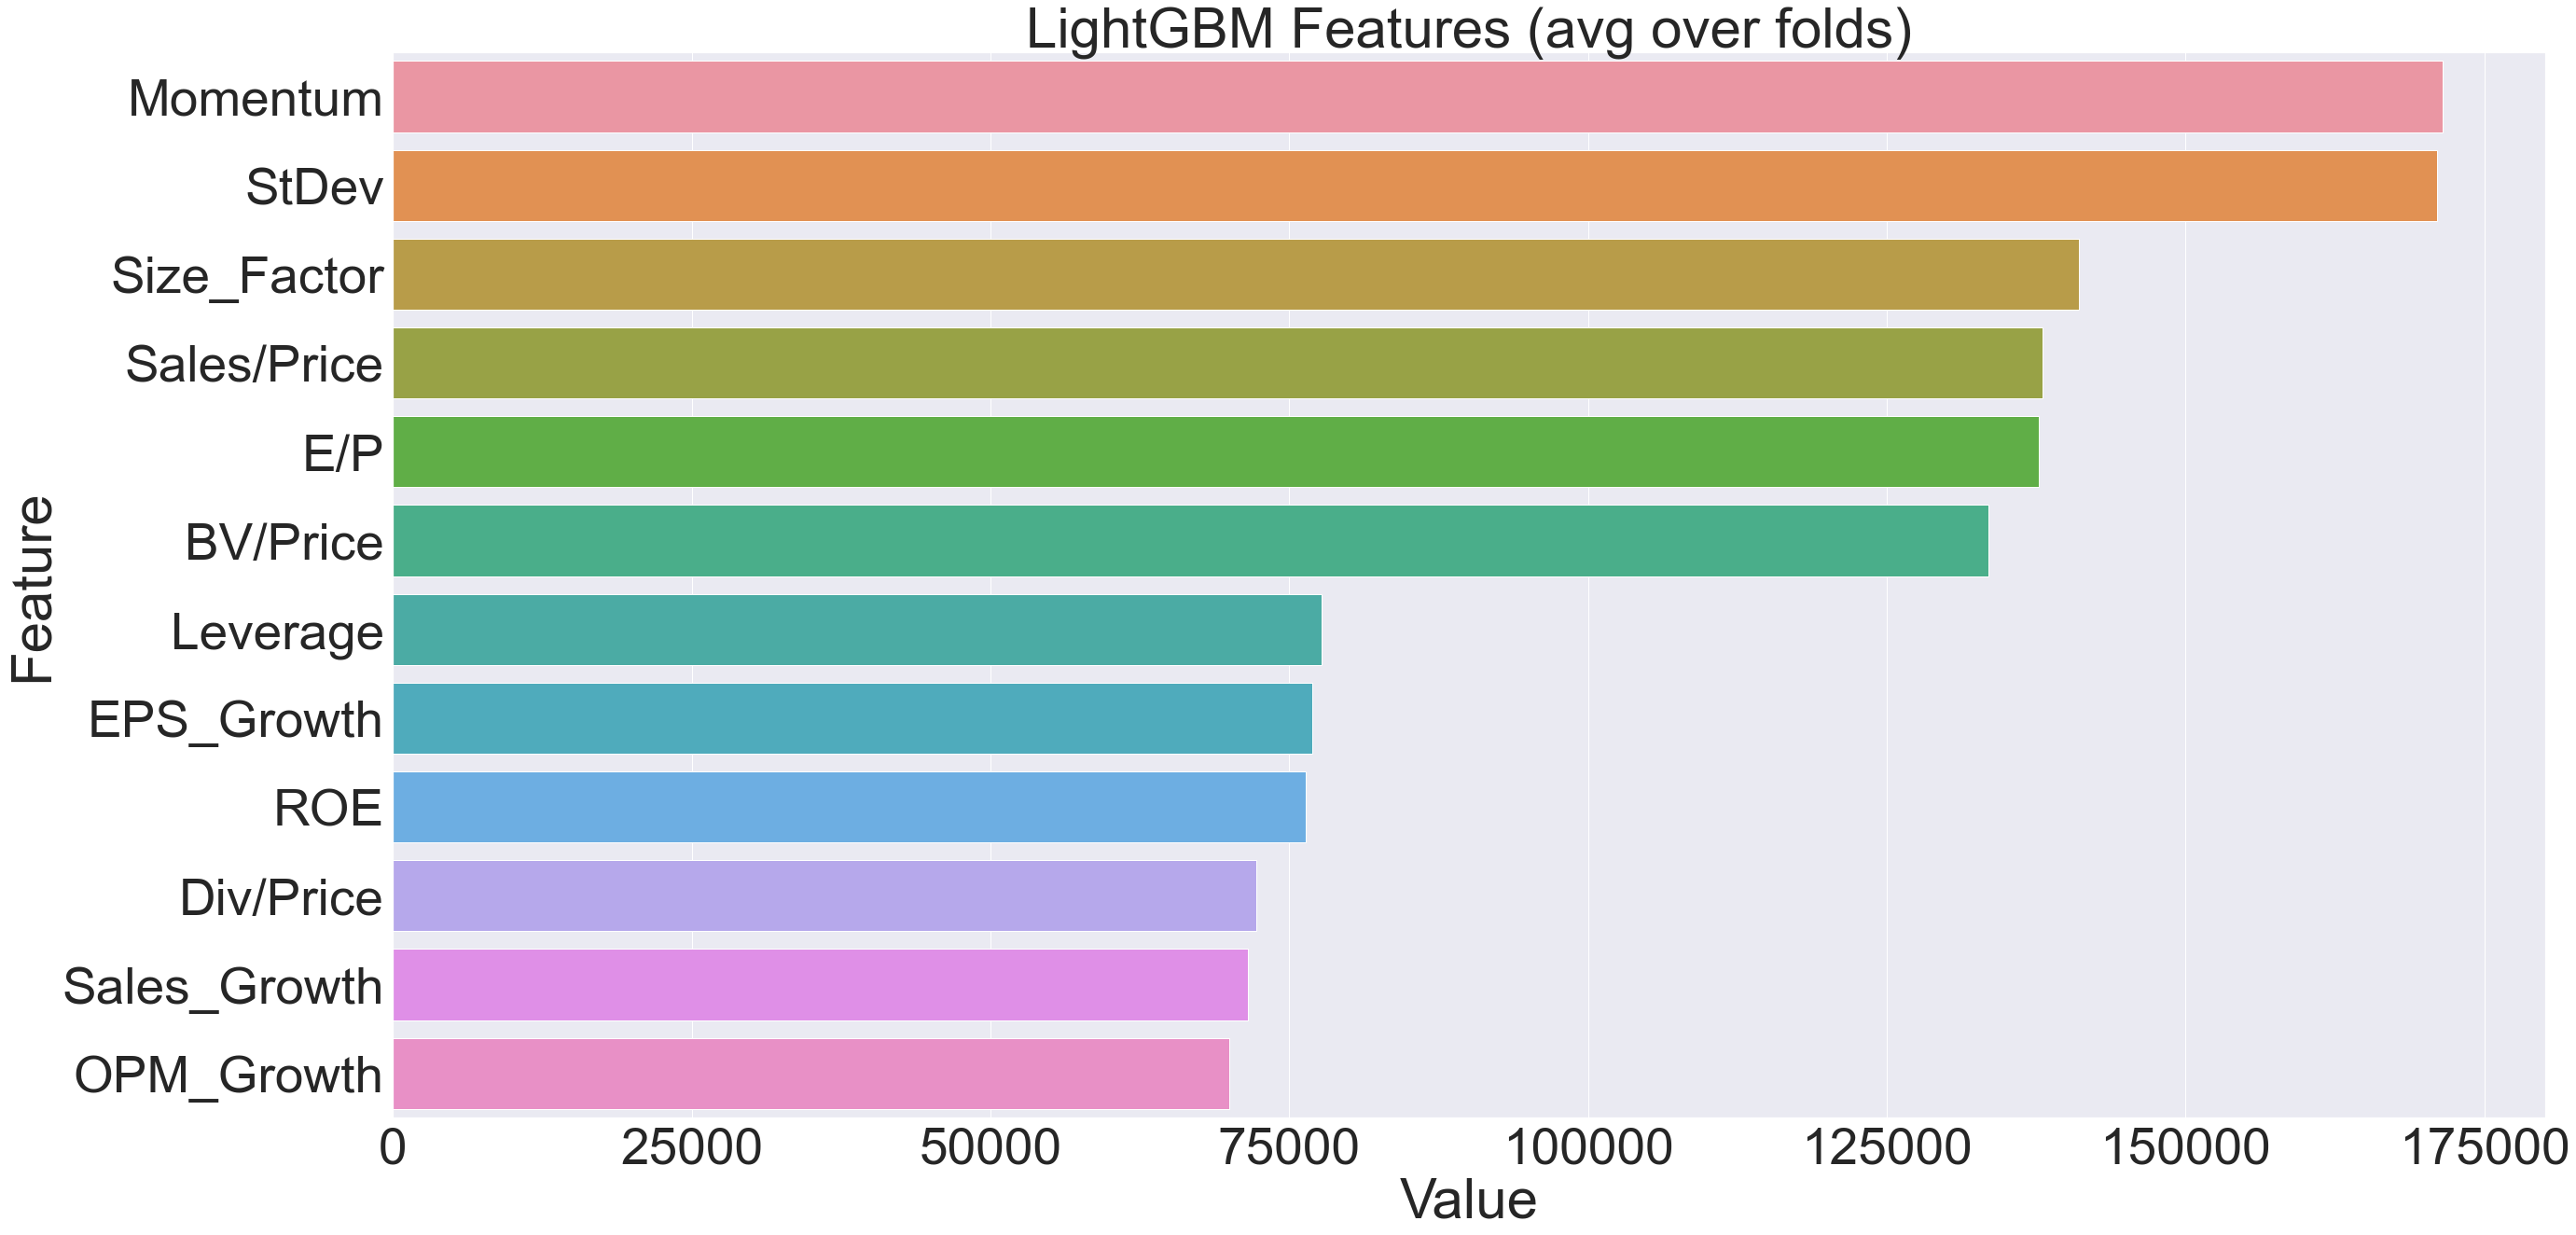

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
X_Features=read_data[['Momentum', 'StDev','Sales_Growth', 'OPM_Growth', 'EPS_Growth','E/P',
       'Size_Factor','ROE', 'Leverage','Sales/Price', 'BV/Price','Div/Price']]
plotImp(lgbm,X_Features,num=25)

# Dump data to disk for Backtesting

In [31]:
read_data.to_csv("data/Prediction_Output.csv")

In [32]:
read_data.tail()

,Unnamed: 0,Company Name,Industry,Symbol,Capitalization,Date,Open,High,Low,Close,...,BV/Price,PEG,Div/Price,Size_Factor,Quality,Value,Cum_Return,LGBM_Prob_2.0%hit,LGBM_Prob_5.0%hit,LGBM_Prob_7.5%hit
704512,704512.0,eClerx Services Ltd.,IT,ECLERX,SMALLCAP,2020-12-07,785.000000,804.000000,785.0,787.799988,...,252.0,-42.255084,80.0,307.0,3.474359,0.518431,NaN,0.564256,0.765666,0.423566
704513,704513.0,eClerx Services Ltd.,IT,ECLERX,SMALLCAP,2020-12-08,794.700012,819.000000,770.0,774.500000,...,253.0,-42.255084,81.0,307.0,3.474359,0.526787,NaN,0.620312,0.498498,0.403476
704514,704514.0,eClerx Services Ltd.,IT,ECLERX,SMALLCAP,2020-12-09,781.000000,822.049988,781.0,817.349976,...,250.0,-42.255084,77.0,305.0,3.474359,0.500838,NaN,0.706166,0.224831,0.174024
704515,704515.0,eClerx Services Ltd.,IT,ECLERX,SMALLCAP,2020-12-10,817.000000,817.000000,787.0,802.150024,...,251.0,-42.255084,78.0,305.0,3.474359,0.509725,NaN,0.408875,0.345432,0.157377
704516,704516.0,eClerx Services Ltd.,IT,ECLERX,SMALLCAP,2020-12-11,799.049988,834.000000,799.0,808.900024,...,249.0,-42.255084,78.0,307.0,3.474359,0.505737,NaN,0.426057,0.413498,0.100305
